In [18]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
import sklearn
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [72]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_localize('UTC')
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [73]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,aBikeStress,aVI,aPower Efficiency Factor,aBikeStress per hour,Aerobic Decoupling,Power Index,Activities,To Exhaustion,Elapsed Time,Duration,Time Moving,Time Carrying (Est),Elevation Gain Carrying (Est),Distance,Climb Rating,Athlete Weight,Athlete Bodyfat,Athlete Bones,Athlete Muscles,Athlete Lean Weight,Athlete Bodyfat Percent,Elevation Gain,Elevation Loss,Work,Average Speed,Average Power,Average SmO2,Average tHb,Average aPower,Nonzero Average Power,Average Heart Rate,Average Core Temperature,Heartbeats,HrPw Ratio,Workbeat stress,Watts:RPE Ratio,Power Percent of Max,HrNp Ratio,Average Cadence,Average Temp,Max Power,Max SmO2,Max tHb,Min SmO2,Min tHb,Max Heartrate,Min Heartrate,Max Core Temperature,Max Speed,Max Cadence,Max Temp,Min Temp,95% Heartrate,VAM,Effect of Altitude,Gradient,Average Power Variance,Max Power Variance,Average Left Torque Effectiveness,Average Right Torque Effectiveness,Average Left Pedal Smoothness,Average Right Pedal Smoothness,Average Left Pedal Center Offset,Average Right Pedal Center Offset,Average Left Power Phase Start,Average Right Power Phase Start,Average Left Power Phase End,Average Right Power Phase End,Average Left Peak Power Phase Start,Average Right Peak Power Phase Start,Average Left Peak Power Phase End,Average Right Peak Power Phase End,Average Left Power Phase Length,Average Right Power Phase Length,Average Left Peak Power Phase Length,Average Right Peak Power Phase Length,Calories (HR),Checksum,Aerobic TISS,Anaerobic TISS,Critical Power,xPower,Relative Intensity,BikeScore,Skiba VI,TISS Aerobicity,Response Index,IsoPower,BikeIntensity,BikeStress,VI,Efficiency Factor,BikeStress per hour,Exhaustion Best R,Daniels Points,Daniels EqP,LNP,RTP,xPace,IWF,GOVSS,H1 Time in Zone,H2 Time in Zone,H3 Time in Zone,H4 Time in Zone,H5 Time in Zone,H6 Time in Zone,H7 Time in Zone,H8 Time in Zone,H9 Time in Zone,H10 Time in Zone,H1 Percent in Zone,H2 Percent in Zone,H3 Percent in Zone,H4 Percent in Zone,H5 Percent in Zone,H6 Percent in Zone,H7 Percent in Zone,H8 Percent in Zone,H9 Percent in Zone,H10 Percent in Zone,Left/Right Balance,P1 Time in Pace Zone,P2 Time in Pace Zone,P3 Time in Pace Zone,P4 Time in Pace Zone,P5 Time in Pace Zone,P6 Time in Pace Zone,P7 Time in Pace Zone,P8 Time in Pace Zone,P9 Time in Pace Zone,P10 Time in Pace Zone,P1 Percent in Pace Zone,P2 Percent in Pace Zone,P3 Percent in Pace Zone,P4 Percent in Pace Zone,P5 Percent in Pace Zone,P6 Percent in Pace Zone,P7 Percent in Pace Zone,P8 Percent in Pace Zone,P9 Percent in Pace Zone,P10 Percent in Pace Zone,10 sec Peak Pace,15 sec Peak Pace,20 sec Peak Pace,30 sec Peak Pace,1 min Peak Pace,2 min Peak Pace,3 min Peak Pace,5 min Peak Pace,8 min Peak Pace,10 min Peak Pace,20 min Peak Pace,30 min Peak Pace,60 min Peak Pace,90 min Peak Pace,10 sec Peak Pace Swim,15 sec Peak Pace Swim,20 sec Peak Pace Swim,30 sec Peak Pace Swim,1 min Peak Pace Swim,2 min Peak Pace Swim,3 min Peak Pace Swim,5 min Peak Pace Swim,8 min Peak Pace Swim,10 min Peak Pace Swim,20 min Peak Pace Swim,30 min Peak Pace Swim,60 min Peak Pace Swim,90 min Peak Pace Swim,Best 50m,Best 100m,Best 200m,Best 400m,Best 500m,Best 800m,Best 1000m,Best 1500m,Best 2000m,Best 3000m,Best 4000m,Best 5000m,Best 10km,Best 15km,Best 20km,Best Half Marathon,Best 30km,Best 40km,Best Marathon,1 min Peak Pace HR,5 min Peak Pace HR,10 min Peak Pace HR,20 min Peak Pace HR,30 min Peak Pace HR,60 min Peak Pace HR,MMP Percentage,Power Zone,Fatigue Index,Pacing Index,1 sec Peak Power,5 sec Peak Power,10 sec Peak Power,15 sec Peak Power,20 sec Peak Power,30 sec Peak Power,1 min Peak Power,2 min Peak Power,3 min Peak Power,5 min Peak Power,8 min Peak Power,10 min Peak Power,20 min Peak Power,30 min Peak Power,60 min Peak Power,90 min Peak Power,1 min Peak Power HR,5 min Peak Power HR,10 min Peak Power HR,20 min Peak Power HR,30 min Peak Power HR,60 min Peak Power HR,Hr Zone,1 min Peak Hr,2 m

The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [21]:
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = None

In [102]:
df = strava.join(cheetah,how='inner')
df = df.dropna()
df = df[df['Average Cadence']!= 0]
df = df[[
    'time',
    'average_heartrate',
    'average_temp',
    'average_watts',
    'device_watts',
    'distance',
    'elapsed_time',
    'elevation_gain',
    'kudos',
    'moving_time',
    'workout_type',
    'Average Speed',
    'Nonzero Average Power',
    'Average Cadence',
    'VAM',
    'Calories (HR)',
    '1 sec Peak Power',
    '1 min Peak Hr',
    'NP',
    'TSS'
]]
#only keep intresting columns and mentioned before
df = df[df['device_watts'] == True]
df['time_hour'] = (pd.to_timedelta(df['time'],unit='m')).astype('timedelta64[m]')/60
display(df.head(20))
#remove records with no device watts
df.isna().sum().sum() == 0 #assert we have 0 nulls

,time,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,Average Speed,Nonzero Average Power,Average Cadence,VAM,Calories (HR),1 sec Peak Power,1 min Peak Hr,NP,TSS,time_hour
2018-01-27 19:39:49+00:00,06:39:49,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,26.0234,191.923,64.9866,265.983,201.970,664,143.000,222.856,20.2257,6.650000
2018-01-27 20:01:32+00:00,07:01:32,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,34.4380,231.369,71.5892,321.004,1044.550,766,166.233,245.365,94.5787,7.016667
2018-02-05 21:06:42+00:00,08:06:42,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,22.2417,225.094,62.2433,308.571,743.167,846,161.117,253.702,98.3269,8.100000
2018-02-07 06:59:05+00:00,17:59:05,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,20.7841,204.398,65.1407,339.005,1655.090,786,206.826,232.644,171.0780,17.983333
2018-02-09 19:18:03+00:00,06:18:03,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,25.6585,189.786,69.3056,158.763,1659.260,784,164.617,212.726,147.7970,6.300000
2018-02-10 20:21:37+00:00,07:21:37,103.9,17.0,134.9,True,7.8,19,92.00 m,8,18,Ride,25.3779,181.753,59.2450,221.205,165.419,638,189.450,192.117,15.7590,7.350000
2018-02-10 20:46:02+00:00,07:46:02,152.1,19.0,198.9,True,31.0,49,387.00 m,21,49,Race,37.3383,254.178,74.8547,329.850,811.304,733,172.850,244.500,69.2902,7.766667
2018-02-14 20:07:12+00:00,07:07:12,125.3,19.0,148.9,True,47.8,143,922.00 m,6,132,Ride,21.3443,206.801,65.4410,348.204,1641.700,762,168.867,222.957,155.9740,7.116667
2018-02-16 19:19:04+00:00,06:19:04,124.9,20.0,159.6,True,58.6,212,659.00 m,19,132,Ride,26.3147,206.012,72.2824,141.454,1622.360,835,162.633,222.469,154.5070,6.316667
2018-02-17 19:06:26+00:00,06:06:26,123.7,17.0,158.7,True,20.1,49,244.00 m,8,46,Ride,25.6788,188.233,70.6459,262.574,560.423,502,152.850,211.950,49.1852,6.100000


True

## Cleaning

here i have cleaned the data, after inspecting the data later on in my analysis i realized there are quite a few feilds with data stacking up at 0 (or in the case of the temp reading from cheetah -255) i opted to prune these out of the data as they worsened my regression errors and dont seem to be real observations but instead missing values.

## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


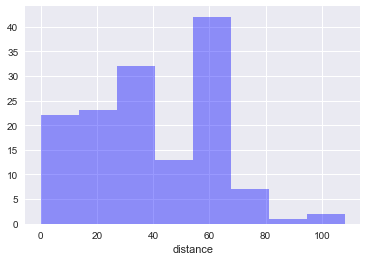

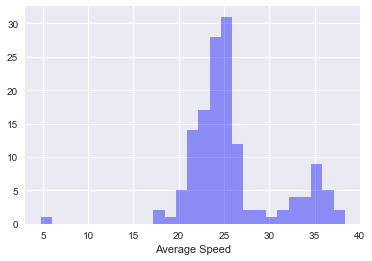

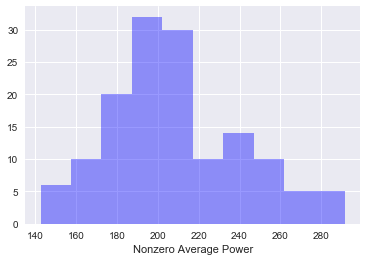

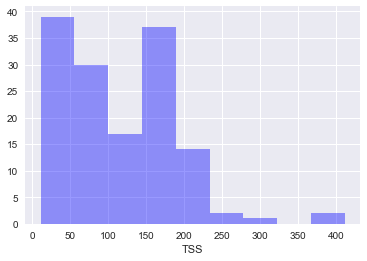

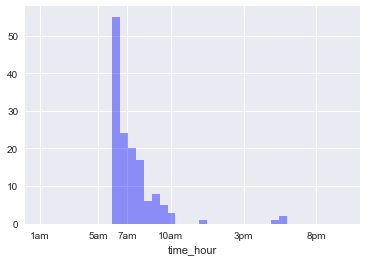

In [147]:
plt.tight_layout()

for key in ['distance', 'Average Speed', 'Nonzero Average Power', 'TSS']:
    sns.distplot(df[key],kde=False,color=sns.saturate('b'))
    plt.show()

    fig, ax = plt.subplots()
sns.distplot(df['time_hour'],kde=False,ax=ax,color=sns.saturate('b'));
plt.xlim(0,23)
plt.xticks([1,5,7,10,15,20],['1am','5am','7am','10am','3pm','8pm'])
plt.show()
None

# Distribution of data  


Normal distribution  


#### average (heartrate/temp/watts)
In the above graph we can see these all seem to be normaly distributed

#### kudos
looks like kudos may also be normaly distributed

#### distance
distance may also be normally distributed but the case seems weaker

#### elapsed time and moving time 
both do not seem to be normaly distributed

In [56]:
from matplotlib import colors as cols

print(df.columns.values)
correl = df[[
    'distance',
    'moving_time',
    'Average Speed'
    'average_heartrate',
    'Power (watts)',
    'Normalised power (NP)',
    'Training Stress Score',
    'Elevation Gain']].corr()

fig, ax = plt.subplots(figsize=(30,30))
ax.tick_params(which='both', labelsize=40)
sns.heatmap(correl,ax=ax, cmap='coolwarm',square=True, annot=True, annot_kws={"size": 20},linewidths=.5,center=0, vmin=-1, vmax=1)

['average_heartrate' 'average_temp' 'average_watts' 'device_watts'
 'distance' 'elapsed_time' 'elevation_gain' 'kudos' 'moving_time'
 'workout_type' 'Average Speed' 'Nonzero Average Power' 'Average Cadence'
 'VAM' 'Calories (HR)' '1 sec Peak Power' '1 min Peak Hr' 'NP' 'TSS']


KeyError: ('distance', 'Moving Time', 'Average SpeedHeart Rate', 'Power (watts)', 'Normalised power (NP)', 'Training Stress Score', 'Elevation Gain')

# Correlation
<br/>

above is a "corelation" matrix.

simply white squares represent no correlation, red represent positive and blue negative, the stronger the colour the stronger the correlation

this is done via [linear regression](https://en.wikipedia.org/wiki/Linear_regression) <br/><br/>

note the strong red on the diagonals is only there as "somevalue" will allways correlate 1:1 with itself

typicaly .25 is considerd a weak correaltion .5 moderate and .75 verry strong

most values of intrest seem to be located in the bottom righthand corner <br/>  <br/>

it is importnant to note that some of these correaltions may be trivial observations or tell us verry little

for instance **elapsed_time** and **moving_time** have a strong correlation, but they are both mesures of time and one would expect them to be correalted

<br/><br/>
here the region of intrest is the red square near distance and time as it has most of the strong correlations

In [25]:
import numpy as np

def getRowCorrel(key):
    fig, ax = plt.subplots(figsize=(20,20))
    row = pd.DataFrame([correl[key]]).drop(key,axis='columns')
    mat = ax.matshow(row,cmap='coolwarm', norm =cols.Normalize(-1,1))
    plt.xticks(range(row.shape[1]), row.columns.values, fontsize=20, rotation=45)
    plt.grid(b=None)
    plt.yticks([])
    plt.ylabel(key.replace("_", "\n"),fontsize=20,rotation=0,labelpad=50)
    for (i, j), z in np.ndenumerate(row):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize =20)
        
    plt.show()

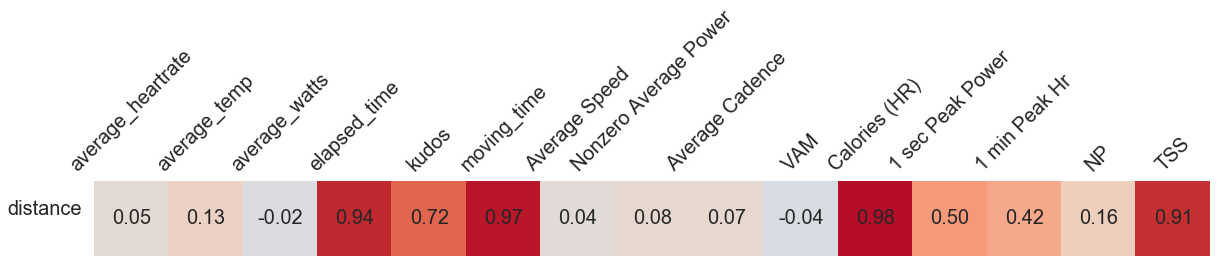

In [26]:
getRowCorrel('distance')

## Distance

here we can see distance has a strong correlaton with moving time and elapsed time (to be expected)

aswell as a strong correlation with kudos witch is a much more intresting observation as it isnt obviously dependant on time

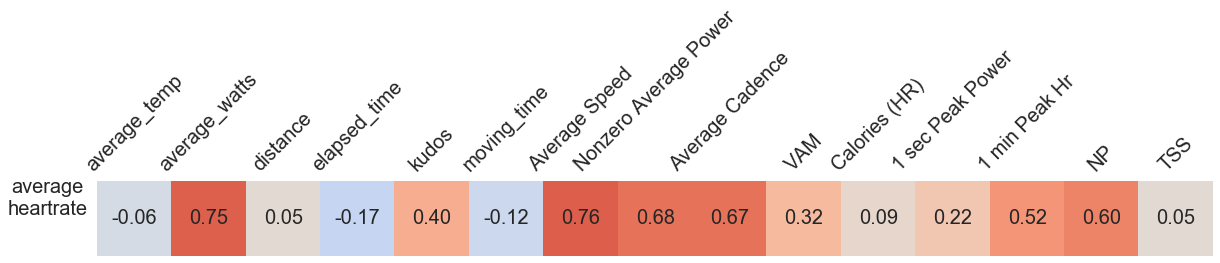

In [27]:
getRowCorrel('average_heartrate')

## Heart rate

Heartrate has a moderate correlation with average watts aswell as a weaker one with kudos

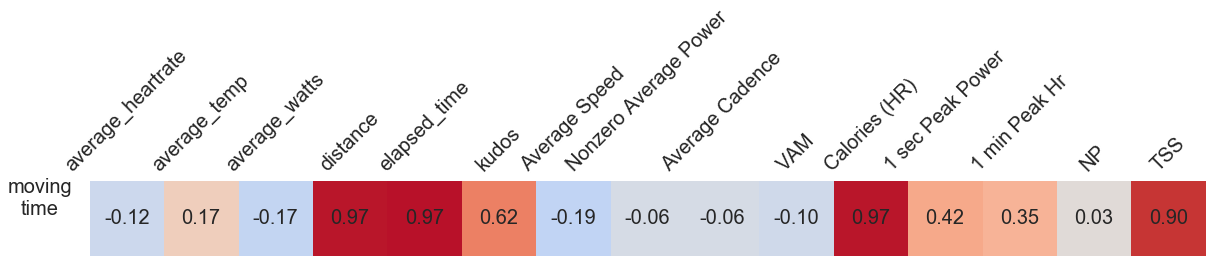

In [28]:
getRowCorrel('moving_time')

## Moving time

moving time has a strong correlation with distance and elapsed time

more intrestingly it has a correlation with kudos however it is not as strong

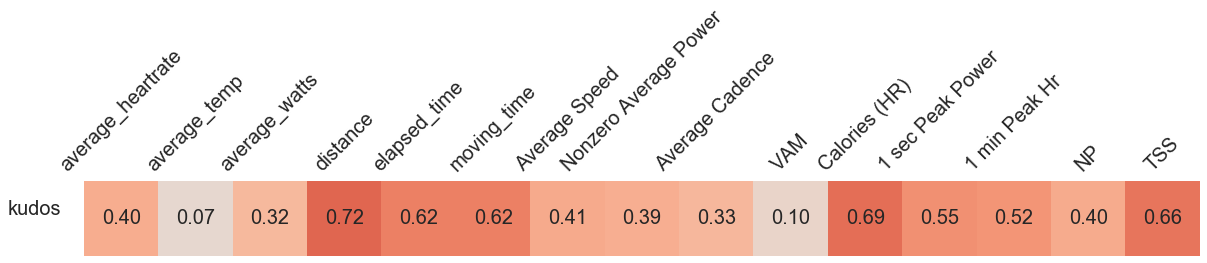

In [29]:
getRowCorrel('kudos')

## Kudos

## Workout Types

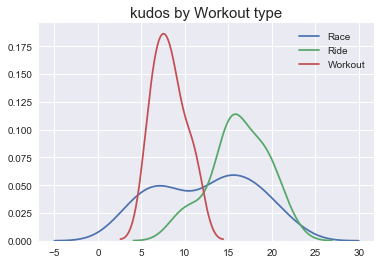

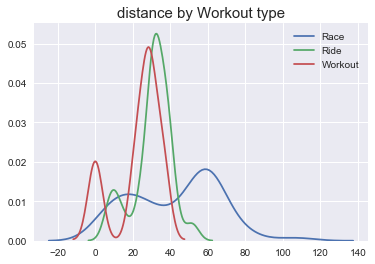

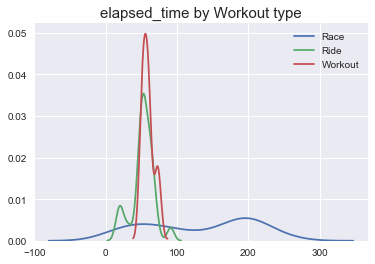

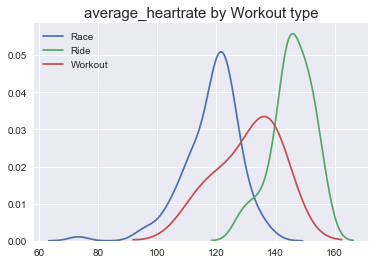

In [52]:
ride = df[df['workout_type'] == 'Ride']
race = df[df['workout_type'] == 'Race']
workout = df[df['workout_type'] == 'Workout']

workoutGroups = [ride,race,workout]
names = ['Race','Ride','Workout']

def plotMulti(subSets,names,feild):
    fig, ax = plt.subplots()
    for item,name in zip(subSets,names):
        sns.kdeplot(item[feild],label=name,ax=ax)
    ax.set_title(f"{feild} by workout type",fontsize=15)
    plt.show()

plotMulti(workoutGroups,names,'kudos')
plotMulti(workoutGroups,names,'distance')
plotMulti(workoutGroups,names,'elapsed_time')
plotMulti(workoutGroups,names,'average_heartrate')


None

 Mean Squared Error: 8.504909434699139
 Root Mean Squared Error: 2.916317786987409
 Colums Kept: average_temp, distance, elapsed_time, moving_time, Average Speed, Nonzero Average Power, Average Cadence


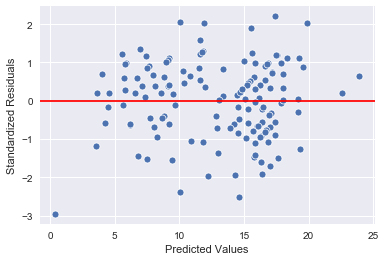

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import math
#its worth noting i am traning and testing on the same data here

estimator = sklearn.linear_model.LinearRegression()
predictors = df[[x for x in correl.columns.values if x != 'kudos']]
selector = sklearn.feature_selection.RFE(estimator,step=1)
selector = selector.fit(predictors,df['kudos'])
predicted = selector.predict(predictors)
residuals = predicted -df['kudos']
mse =  (residuals  ** 2).sum()/len(residuals)
rmse = math.sqrt(mse)
supportCols = predictors.columns.values[selector.support_]
prunedCols = predictors.columns.values[~selector.support_]

print(f' Mean Squared Error: {mse}\n',
      f'Root Mean Squared Error: {rmse}\n',
      f'Colums Kept: {", ".join(supportCols)}')
residualScaler = StandardScaler()
residualScaler = residualScaler.fit(pd.DataFrame({'data':residuals}))
sns.scatterplot(predicted,residualScaler.transform([residuals])[0])
plt.ylabel("Standardized Residuals")
plt.xlabel("Predicted Values")
plt.title = 'Residual Plot'
plt.axhline(color='r')
plt.show()

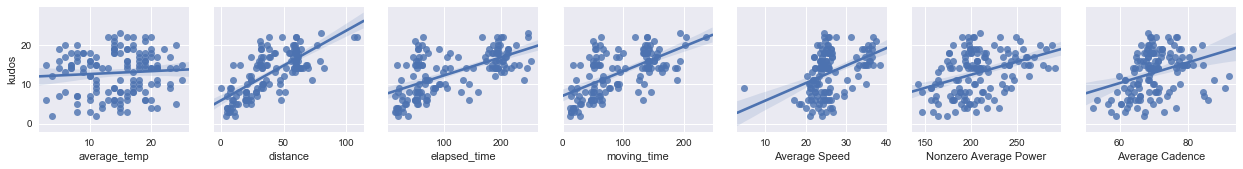

In [57]:
sns.pairplot(df,x_vars=supportCols,y_vars='kudos',palette='reds',kind='reg')
None

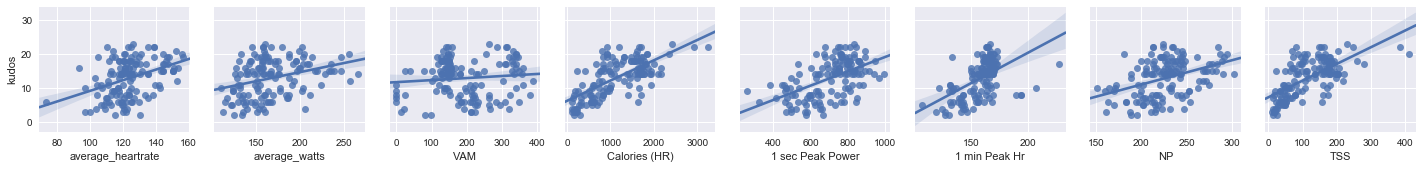

In [58]:
sns.pairplot(df,x_vars=prunedCols,y_vars='kudos',palette='blues',kind='reg')
None

## Kudos
#### bonus question

Here we can see kudos has a strong correlation with distance and a moderate correlation with both time variables

it would appear going for a long and far workout is the best way to gain "kudos" 

intestingly nothing has a negative correlation with kudos meaning for the given features nothing will hurt your gain of "kudos" 

for this i also included the scatter plots so one can eyball if the correlations seem to make sense